# Chest X-Ray detection through ResNet

Deep Learning has been revolutionizing Healthcare and Medicine. What's happening is that Neural Networks have reached a level of accuracy that for some tasks, like medical imagery, drug research, genome development. They are simply better than humans, even if compared to a team of specialists. For instance, in 2018 The Guardian reported a study that was showing how skin cancer was detected more accurately by Deep Learning than by dermatologists. According to this study, human dermatologists were reaching a 86.6%, while deep learning model's accuracy was 95%.
We have been provided with 133 images belonging to 4 classes: 
<ul>
    <li>Healthy</li>
    <li>Covid-19</li>
    <li>Bacterial Pneumonia</li>
    <li>Viral Pneumonia</li>
</ul>
We will try <em>Convolutional Neural Network</em> models and, specifically, we'll be using <em>ResNet</em> a pretrained model including <em>skip connection</em> features, which are probably the best way to bypass the <em>vanishing gradient problem</em>, an issue affecting recurrent neural networks training, only partially solved by LSTMs.
<br><br>
Let's get started!

## Import libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import tensorflow as tf
#from tensorflow.keras import layers, optimizers
#from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
#from tensorflow.keras.models import Model, load_model
#from tensorflow.keras import backend as K
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [2]:
# Specify training data directory

XRay_Directory = 'Chest_X_Ray/train'

In [3]:
# List the folders in the directory

os.listdir(XRay_Directory)

['.DS_Store', '0', '1', '3', '2']

In [4]:
# Use image generator to generate tensor images data and normalize them
# Use 20% of the data for cross-validation  

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255, 
                                                                  validation_split= 0.2)

In [5]:
# Generate batches of 40 images
# Total number of images is 133*4 = 532 images
# Training is 428 (80%) and validation is 104 (20%)
# Perform shuffling and image resizing

train_generator = image_generator.flow_from_directory(batch_size = 40, 
                                                      directory= XRay_Directory, 
                                                      shuffle= True, 
                                                      target_size=(256,256), 
                                                      class_mode = 'categorical', 
                                                      subset="training")

Found 428 images belonging to 4 classes.


In [6]:
# same for validation_generator

validation_generator = image_generator.flow_from_directory(batch_size = 40, 
                                                           directory= XRay_Directory, 
                                                           shuffle= True, 
                                                           target_size=(256,256), 
                                                           class_mode = 'categorical', 
                                                           subset="validation")

Found 104 images belonging to 4 classes.


In [7]:
# Generate a batch of 40 images and labels
# remember that batch_size is set to 40

train_images, train_labels = next(train_generator)

In [8]:
# 40 images, 256x256x3

train_images.shape

(40, 256, 256, 3)

In [9]:
# 40 labels, 4 ohe

train_labels.shape

(40, 4)

In [10]:
# in this dataset, we don't have patients with more than one condition

train_labels

array([[0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]],

In [11]:
# labels translator 

label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

## Visualize Datasets

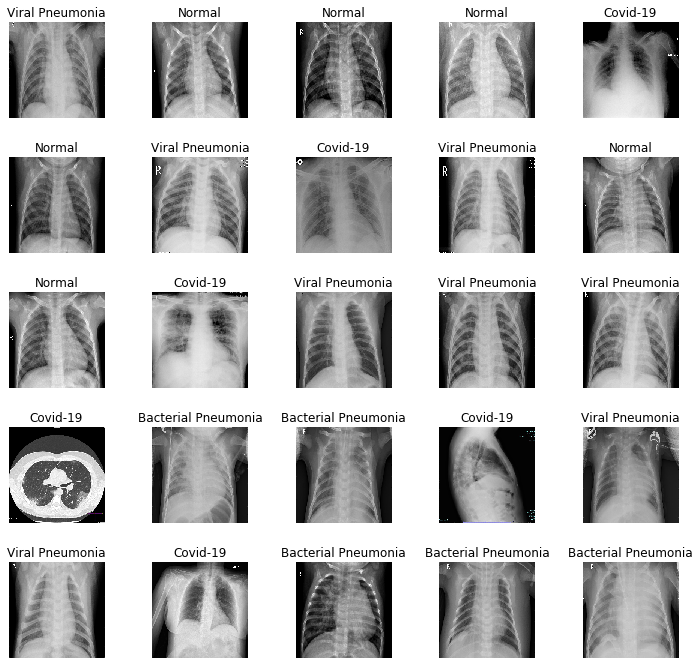

In [12]:
# Create a grid of 16 images along with their corresponding labels
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5) 

## Import model with pretrained weights

In [13]:
basemodel = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                    include_top = False, 
                                                    input_tensor = tf.keras.layers.Input(shape=(256,256,3)))

In [14]:
# freezing the model upto the last stage - 4 and re-training stage -5 

for layer in basemodel.layers[:-10]:
  layer.trainable = False

In [15]:
basemodel.summary()

# We have 4.5M trainable parameters, out of 23.5M

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

## Build and train Deep Learning model

In [16]:
# building the hat of the model

headmodel = basemodel.output
headmodel = tf.keras.layers.AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = tf.keras.layers.Flatten(name= 'flatten')(headmodel)
headmodel = tf.keras.layers.Dense(256, activation = "relu")(headmodel)
headmodel = tf.keras.layers.Dropout(0.3)(headmodel)
headmodel = tf.keras.layers.Dense(128, activation = "relu")(headmodel)
headmodel = tf.keras.layers.Dropout(0.2)(headmodel)
headmodel = tf.keras.layers.Dense(4, activation = 'softmax')(headmodel)

model = tf.keras.models.Model(inputs=basemodel.input, outputs=headmodel)

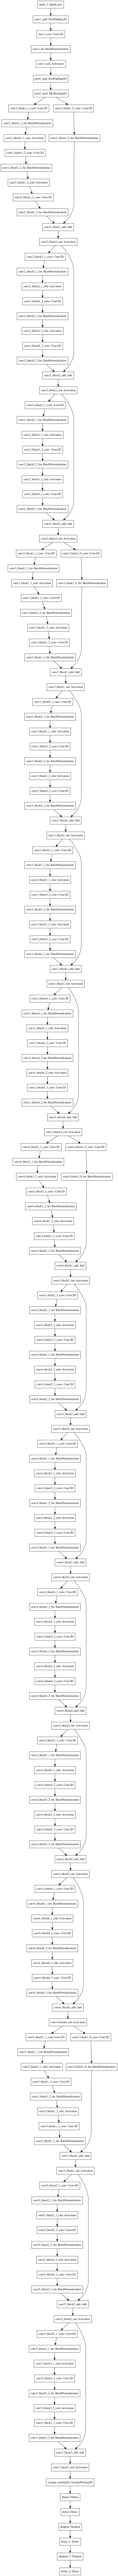

In [17]:
# if we want to check the structure, graphically

tf.keras.utils.plot_model(model, show_shapes=False)

In [18]:
# compiling the model

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [19]:
# using early stopping to exit training if validation accuracy is not increasing even after certain epochs (patience)

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)

In [20]:
# saving the best model with lower validation loss

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath="weights.hdf5", monitor="val_accuracy",
                                                  verbose=1, save_best_only=True)

In [21]:
# creating train_generator and val_generator

train_generator = image_generator.flow_from_directory(batch_size = 4, 
                                                      directory= XRay_Directory, 
                                                      shuffle= True, 
                                                      target_size=(256,256), 
                                                      class_mode= 'categorical', 
                                                      subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 4, 
                                                    directory= XRay_Directory, 
                                                    shuffle= True, 
                                                    target_size=(256,256), 
                                                    class_mode= 'categorical', 
                                                    subset="validation")

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [22]:
# training our model

history = model.fit(train_generator, 
                    steps_per_epoch=train_generator.n//4, 
                    epochs = 20, 
                    validation_data= val_generator, 
                    validation_steps=val_generator.n//4, 
                    callbacks=[checkpointer, earlystopping])

Epoch 1/20
107/107 [==============================] - 76s 679ms/step - loss: 1.4353 - accuracy: 0.3271 - val_loss: 1.3065 - val_accuracy: 0.4519

Epoch 00001: val_accuracy improved from -inf to 0.45192, saving model to weights.hdf5


/Users/maurizioscibilia/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
107/107 [==============================] - 70s 654ms/step - loss: 1.0706 - accuracy: 0.5234 - val_loss: 1.1702 - val_accuracy: 0.3942

Epoch 00002: val_accuracy did not improve from 0.45192
Epoch 3/20
107/107 [==============================] - 69s 648ms/step - loss: 0.9408 - accuracy: 0.6192 - val_loss: 0.9584 - val_accuracy: 0.5096

Epoch 00003: val_accuracy improved from 0.45192 to 0.50962, saving model to weights.hdf5
Epoch 4/20
107/107 [==============================] - 76s 708ms/step - loss: 0.8296 - accuracy: 0.6589 - val_loss: 0.8673 - val_accuracy: 0.6538

Epoch 00004: val_accuracy improved from 0.50962 to 0.65385, saving model to weights.hdf5
Epoch 5/20
107/107 [==============================] - 71s 660ms/step - loss: 0.7297 - accuracy: 0.7173 - val_loss: 0.7237 - val_accuracy: 0.7500

Epoch 00005: val_accuracy improved from 0.65385 to 0.75000, saving model to weights.hdf5
Epoch 6/20
107/107 [==============================] - 69s 648ms/step - loss: 0.6793 - accuracy

## Evaluation

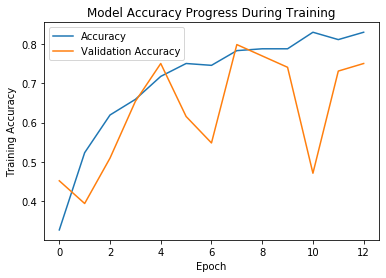

In [23]:
# showing accuracy during training

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend(['Accuracy', 'Validation Accuracy'])

plt.show();

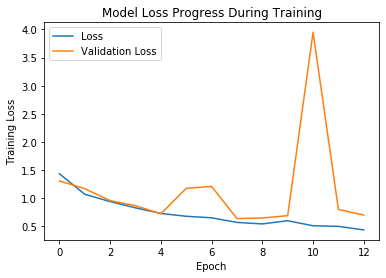

In [24]:
# showing loss during training

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss Progress During Training')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend(['Loss', 'Validation Loss'])

plt.show();

In [25]:
test_directory = 'Chest_X_Ray/test'
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
test_generator = test_gen.flow_from_directory(batch_size = 40, 
                                              directory= test_directory, 
                                              shuffle= True, target_size=(256,256), 
                                              class_mode= 'categorical')
evaluate = model.evaluate(test_generator, steps=test_generator.n//4, verbose=1)
print('Accuracy Test : {}'.format(evaluate[1]))

Found 40 images belonging to 4 classes.
10/10 [==============================] - 5s 6ms/step - loss: 1.0139 - accuracy: 0.6750
Accuracy Test : 0.675000011920929


In [26]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))-1):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)

In [27]:
score = accuracy_score(original,prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.7


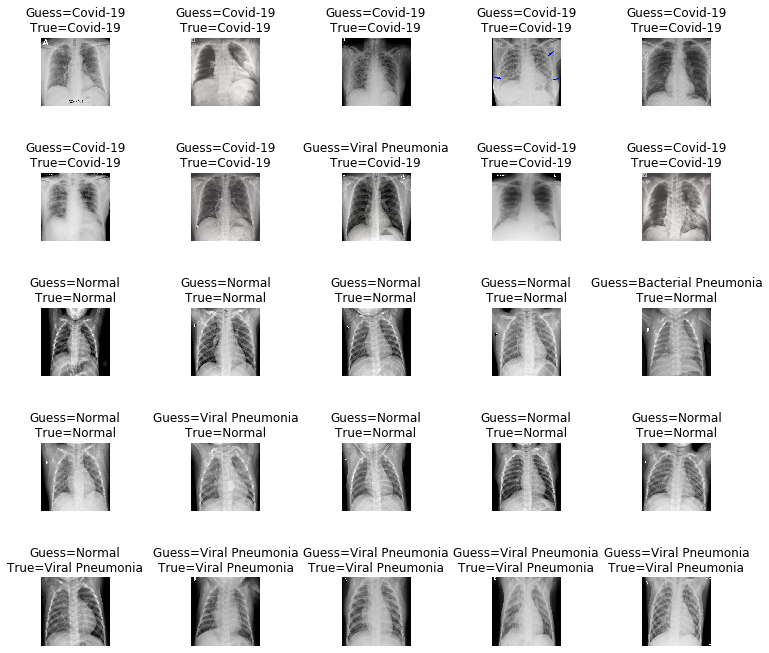

In [28]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title('Guess={}\nTrue={}'.format(str(label_names[prediction[i]]), str(label_names[original[i]])))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 1.2) 

In [29]:
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        10
           1       0.67      0.80      0.73        10
           2       0.67      0.60      0.63        10
           3       0.71      0.50      0.59        10

    accuracy                           0.70        40
   macro avg       0.70      0.70      0.69        40
weighted avg       0.70      0.70      0.69        40



Text(0.5, 1, 'Confusion_matrix')

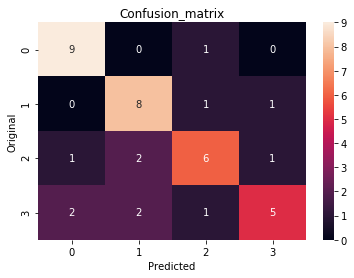

In [30]:
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')

## Conclusions

As we have just seen, with transfer learning we can get results even with a small dataset. It is an amazing opportunity and in this project we have just seen the tip of the iceberg. We got 70% on the test set, composed by <em>unseen</em> data. There are ways to improve our results, a lot of hyperparameter tuning, different models and so on. Many thanks to Dr. Ryan Ahmed Ph.D. MBA for showing this project inside his course on the Udemy platform.